# Small Graph Experiments

In this notebook, there is focus on experimentation with smaller randomly generated graphs whilst comparing with brute force methods to establish how well parition functions can be approximated and the quality of the lower bound curves they produce. At the end is a demonstration of running an experiments on a larger graph - 50 vertices, on one core.

In [279]:
import scipy.io as sio
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import time
import networkx as nx
import cython as cy
import pandas as pd
import os

%cd C:\Users\akash\Documents\MSc Project
G = sio.mmread('G12.mtx')
info = sio.mminfo('G12.mtx')
A = G.toarray() # Adjacency matrix
A = np.abs(A)# number of non zero elements X 1/2 is the number of edges. Number of negatives is number of cuts.

# Default Test Arrays Used in Previous Experiments
ss = np.array([-1,1,1,-1,-1,1])
As = np.abs(np.array([[0,1,0,-1,0,0],[1,0,-1,1,0,0],[0,1,0,0,-1,0],[1,1,0,0,0,1],[0,0,-1,0,0,1],[0,0,0,1,1,0]]))
As2 = np.array([[0,1,0,0,0,0,1],[1,0,0,0,0,1,0],[0,1,0,1,0,1,0],[0,0,1,0,1,0,0],[0,0,0,1,0,1,1],[0,1,1,0,1,0,1],[1,0,0,0,1,1,0]])

# Globals are placed into functions to monitor variables 
global count
global glob_H
global accept_rate
global salvage

C:\Users\akash\Documents\MSc Project


In [2]:
CSV_path = 'C:\\Users\\akash\\Documents\\MSc Project\\CSV_Files\\'

#### Definitions

This cell contains definitions of the functions used in calculating the partition functions and lower bounds

In [864]:
def get_random_s(n): #create an arbitrary set of spins up to n
    s = np.array([[-1,1][np.random.randint(2)] for i in range(0,n)])
    return s    

def calc_rand_H(A,n): # Randomly configures all spins and calculates H given adjacency matrix. Completeley Random.
    H = []
    for i in range(0,n):
        s = []
        while len(s) < A.shape[0]:
            x = random.randint(-1,1)
            if not x == 0:
                s.append(x)
        s=np.array(s)
        H.append(s.T @ A @ s)
        
    return np.array(H),s

def calc_rand_spin_H(A,S_init): # Randomly configures a single spin and calculates H given adjacency matrix   
    
    s=S_init
    r = random.randint(0,A.shape[0]-1)
    s[r] = -s[r]
    
    H = s.T @ A @ s

    return H,s

def generate_random_graph(n): #creates a random adjacency matrix with weights 0 or 1

    a = np.array([[0,1][np.random.randint(2)] for i in range(0,n**2)]).reshape(n,n)
    a[np.tril_indices(n,0)] = 0
    a = a + a.T
    
    return a

def find_all_combinations(n): # returns a 2D array of all combinations of spins from n vertices

    l = list(range(0,2**n))
    l = ["{0:b}".format(i) for i in l]

    b0=[]
    for i in l:
        if len(i) < n:
            for j in range(0,n-len(i)):
                i = '0'+i
  
            b0.append(i)
        else:
            b0.append(i)
           
    b2 = []
    for i in range(0,len(b0)):
        b1 = []
        for char in b0[i]:
            b1.append(int(char))
        b2.append(np.array(b1))
        
    b2 = np.array(b2)    
    b2[b2 == 0] = -1
    
    return b2

def find_minimum_energy(matrix): # finds the minimum energy of the matrix
    
    r = find_all_combinations(matrix.shape[0])
    E,V = (np.einsum('ij,jk,ki->i', r, matrix, r.T),r)
    
    return min(E),E,V

def calc_z_bruteforce(betas,matrix): # Calculates Z brute-force
    
    n = matrix[0].shape[0]
    
    Zb = []
    
    for beta in betas:
        
        z = 0
        
        for j in find_all_combinations(n):
    
            H = j.T @ matrix @ j
            z = z + np.exp(-beta*H)
        
        Zb.append(z)
        
    return np.array(Zb)

def sample_gibbs_state(beta,A,number_of_samples,mixing_time,H_init,S_init): #simulated annealing algorithm to sample Gibbs state
    
    H_old = H_init
    S_old = S_init
    H_samples = []
    S_samples = []
    global accept_rate
    global glob_H
    
    accept_rate = []
    glob_H = []
    
    
    accept_rate_indexed = []
    
    for i in range(0,number_of_samples):
        
        count = 0
        #start = time.time()
        
        for j in range(0,mixing_time):    
        
            H_new,S_new = calc_rand_spin_H(A,S_old)
            
            T = H_old - H_new
            
            if T >= 0:
            
                H_old = H_new
                S_old = S_new
                count = count + 1

            if T < 0 and np.random.uniform() < np.exp(-beta*(np.abs(H_old - H_new))):
                H_old = H_new
                S_old = S_new
                count = count + 1
        
        accept_rate_indexed.append(np.array(count/mixing_time))        
        H_samples.append(H_old)
        glob_H.append(H_samples)
        S_samples.append(S_old)
    
    accept_rate.append((np.mean(accept_rate_indexed),beta))
     
    H_samples = np.array(H_samples)
    
    return (H_samples, S_samples)

def calc_z2z1(beta2,beta1,number_of_sampless,mixing_time,A): #Calcualtes the ratio between zbk+1 and zbk+1
                                                             # from the average of the samples
    H_init,S_init = calc_rand_H(A,1)
    SGS = sample_gibbs_state(beta1,A,number_of_samples,mixing_time,H_init,S_init)
    samples = SGS[0]
    print(type(sample))
    spins = SGS[1]
    
    return np.mean(np.exp(-(beta2-beta1)*samples)),samples,spins

def calc_Zbk(betas,number_of_samples,mixing_time,matrix): #Calculate partition functions up to m, returns numpy array
    
    z = 1
    
    Zb = []
    
    for i in range(0,len(betas)-1):
        ratio,samples,spins = calc_z2z1(betas[i+1],betas[i],number_of_samples,mixing_time,matrix)
        z = z * ratio
        Zb.append(z)
        
    return np.array(Zb)

def get_betas(schedule,beta_cutoff,initial_temperature,alpha,number_points): # produces a vector of betas from 0 to cutoff
                                                                             # given schedule and number of points
    
    if schedule == 'lin':

        betas = np.linspace(0,beta_cutoff,number_points)
        
    if schedule == 'log':
        
        xf = 1.0/(np.exp(initial_temperature/beta_cutoff) - 1)
        x = np.linspace(0,xf,number_points)
        betas = initial_temperature/np.log((1/x)+1)
       
    if schedule == 'geo':
        
        xf = math.log(initial_temperature/beta_cutoff, alpha)  # = 3
        x = np.linspace(0,xf,number_points)
        betas = initial_temperature*(alpha**(-x))
       
    return betas

def plot_LB(betas,z,n): # plots lower bound
    
    x = np.linspace(0,1,300)
    
    E = []
    
    for i in x:
        
        e = []
        
        for k in range(0,len(betas)-1):

            c = ((1/betas[k]) * (-np.log(z[k])-n*i))
            e.append(c)
            
        E.append((1/n)*max(e))
    
    return x, E

#################################################################################################################################
# Redefined Simulated annealing algorithm which collects samples after a burn-in period, rather than collecting one sample from
# after a burn-in.
#################################################################################################################################

def sample_gibbs_state_new(beta,A,number_of_samples,mixing_time,H_init,S_init): 
    #simulated annealing algorithm to sample Gibbs state. This time, samples are collected by first reaching stability after the burn
    # - in time
    
    H_old = H_init
    S_old = S_init
    H_samples = []
    S_samples = []
    
    A = csr_matrix(A)
    
    global accept_rate
    global glob_H
    
    count = 0
    iteration = 0
    t=0
    
    while(len(H_samples) <= number_of_samples):
    
        iteration += 1
        
        H_new,S_new = calc_rand_spin_H(A,S_old)
        T = H_old - H_new
        
        print(T)
        
        if T >= 0:
            H_old = H_new
            S_old = S_new
            count = count + 1
            if iteration >= mixing_time:
                H_samples.append(H_old)
                t+=1
                #print(t)

        if T < 0 and np.random.uniform() < np.exp(-beta*(np.abs(H_old - H_new))):
            H_old = H_new
            S_old = S_new
            count = count + 1
            if iteration >= mixing_time:
                H_samples.append(H_old)
                t+=1
                #print(t)
        
        
        
    
    accept_rate.append(count/iteration)
    
    return (np.array(H_samples), S_samples)


def calc_z2z1_new(beta2,beta1,number_of_sampless,mixing_time,matrix): #Calcualtes the ratio between zbk+1 and zbk, uses the new sampling method
    
    H_init,S_init = calc_rand_H(matrix,1)
    SGS = sample_gibbs_state_new(beta1,matrix,number_of_samples,mixing_time,H_init,S_init)
    samples = SGS[0]
    spins = SGS[1]
    
    return np.mean(np.exp(-(beta2-beta1)*(samples))),samples,spins

def calc_Zbk_new(betas,number_of_samples,mixing_time,matrix): #Calculate partition functions up to m, returns numpy array
    
    global salvage
    salvage = []
    
    z = 1
    
    Zb = []
    
    for i in range(0,len(betas)-1):
        ratio,samples,spins = calc_z2z1_new(betas[i+1],betas[i],number_of_samples,mixing_time,matrix)
        z = z * ratio
        Zb.append(z)
        salvage = Zb
        print(i)
        
    return np.array(Zb)

##### Visualising Random Networks

Below 6 adjacency graphs are generated randomly with vertices defined by the variable n -> 6,8,10,12,15 and 18. All edges have weight 1.

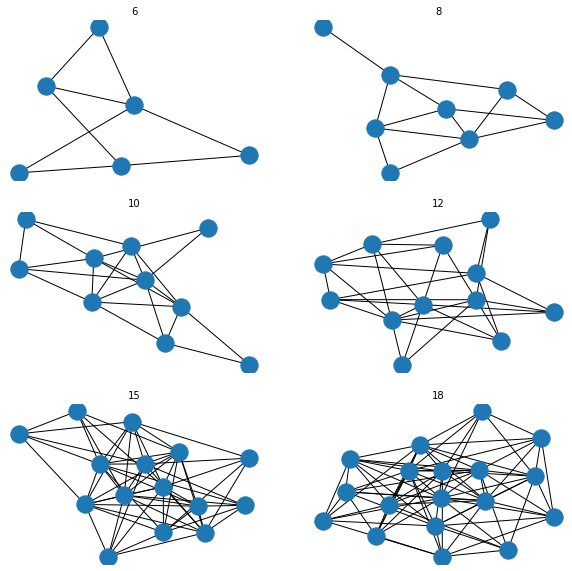

In [59]:
# Generate Random Adjaceny Matrices

n = [6,8,10,12,15,18]
titles = [str(i) for i in n]
fig,axs = plt.subplots(3,2,num=0.5)

fig.set_figheight(10)
fig.set_figwidth(10)
matrices = []
for i,j in enumerate(n):
    
    ix = np.unravel_index(i, axs.shape)
    A = generate_random_graph(j)
    matrices.append(A)
    G = nx.from_numpy_matrix(A)
    
    axs[ix].set_title(titles[i], fontsize=10)
    nx.draw(G, ax=axs[ix])
    
plt.show()

Adjacency matrices are stored and accessed this way after generation.

In [60]:
# save matrices as CSV to load in next time.

for i,j in enumerate(matrices):
    matrices_path = CSV_path + 'matrices {}'.format(titles[i])
    matrices_df = pd.DataFrame(np.array(j).T)
    matrices_df.to_csv(matrices_path)

matrices = []
for i in titles:
    matrices_path = CSV_path + 'matrices {}'.format(i)
    m = pd.read_csv(matrices_path).to_numpy().T
    matrices.append(m[1:len(m)])

In [ ]:
fig,axs = plt.subplots(3,2,num=10)
fig.set_figheight(10)
fig.set_figwidth(10)
fig.subplots_adjust(hspace=0.35)

for i,j in enumerate(cs):

    ix = np.unravel_index(i, axs.shape) 
    axs[ix].plot(j)
    axs[ix].set_title('Matrix ' + str( titles[i]), fontsize=10)
    axs[ix].set_ylabel('Mean Energy')
    axs[ix].set_xlabel('Beta Index')

###### Minimum Energies from BruteForce

In [62]:
for i,matrix in enumerate(matrices):
    print('Matrix:',titles[i],'   ','Minimum Energy:',find_minimum_energy(matrix)[0])

Matrix: 6     Minimum Energy: -12
Matrix: 8     Minimum Energy: -14
Matrix: 10     Minimum Energy: -20
Matrix: 12     Minimum Energy: -36
Matrix: 15     Minimum Energy: -44
Matrix: 18     Minimum Energy: -64


### Solving MAXCUT and Proving Convergence 

###### Linear Schedule

Above the absolute minimum energies are found through brute force, they can be compared with the convergence graphs for both linear and geometric schedules. The assumption is that the mean energy will stabalise to a global optimum, which should coincide with the lowest energy found by the brute force calculation. Convergence graphs below are a plot of the average energy (from the samples) across beta. Beta is chosen as 3.0 to ensure all graphs converge to the lowest possible point.

In [63]:
#Set Hyper-Parameters
schedule = 'lin' #Set beta schedules, 'lin', 'log' or 'geo'
inf_norm = max(np.abs((np.linalg.eig(matrix)[0]))) # infinite norm of matrix is the largest absolute eigenvalue
beta_cutoff = 3.0 #1/(2*inf_norm)
initial_temperature = 0.0001
alpha = 0.85 #for geo schedule
number_beta_points = 350
number_of_samples = 100
mixing_time = 270
betas = get_betas(schedule,beta_cutoff,initial_temperature,alpha,number_beta_points)

In [64]:
# Convergence with a linearly increasing beta schedule
conv_plots = []

for matrix in matrices:

    H_init,S_init = calc_rand_H(matrix,1)
    a1 = []
    for i in betas:
        arr = sample_gibbs_state(i,matrix,number_of_samples,mixing_time,H_init,S_init)
        a1.append(np.mean(arr[0]))
        
    conv_plots.append(a1)

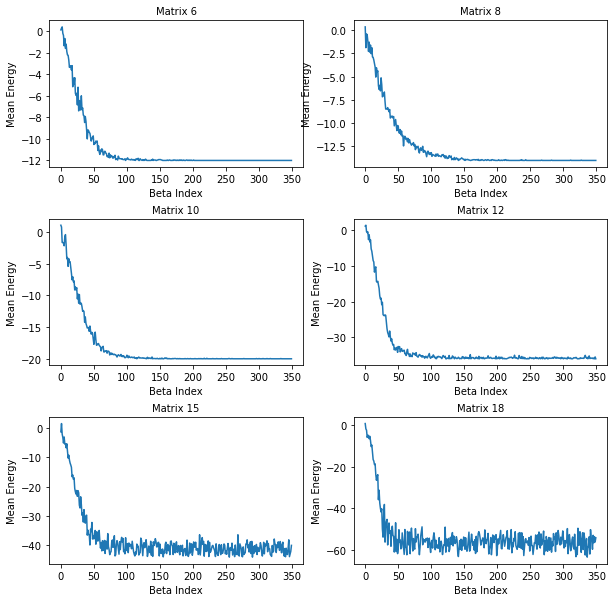

In [65]:
cs1 = CSV_path + 'conv_solve_lin.csv'
conv_solve = pd.DataFrame(np.array(conv_plots).T)
conv_solve.to_csv(cs1)
cs = pd.read_csv(cs1).to_numpy().T
cs=cs[1:len(cs)]

fig,axs = plt.subplots(3,2,num=10)
fig.set_figheight(10)
fig.set_figwidth(10)
#fig.tight_layout(pad = 1.0)
fig.subplots_adjust(hspace=0.35)

for i,j in enumerate(cs):

    ix = np.unravel_index(i, axs.shape)   
    axs[ix].plot(j)
    axs[ix].set_title('Matrix ' + str( titles[i]), fontsize=10)
    axs[ix].set_ylabel('Mean Energy')
    axs[ix].set_xlabel('Beta Index')
    
plt.savefig('conv_solve_lin.pdf')    
plt.show()

###### Geometric Schedule

Using a Geometric schedule, convergence takes a different shape which looks more natural. For both graphs, it seems that convergence becomes more difficult as the graph size increases. This is using the old simulated annealing algorithm

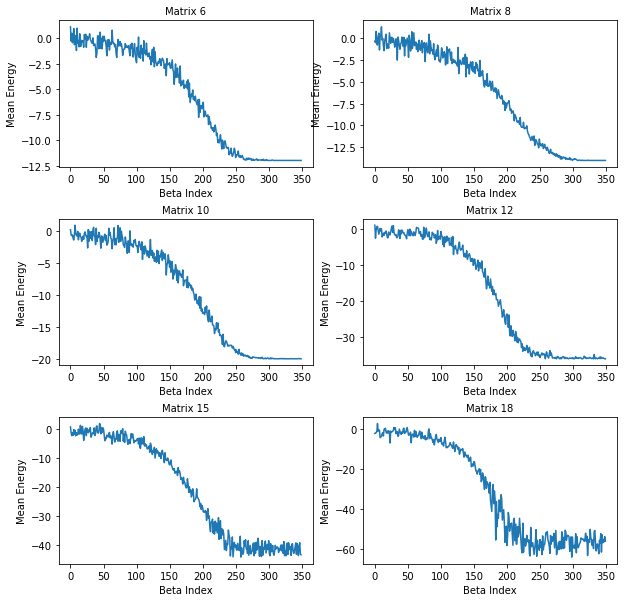

In [66]:
#Set Hyper-Parameters
schedule = 'geo' #Set beta schedules, 'lin', 'log' or 'geo'
inf_norm = max(np.abs((np.linalg.eig(matrix)[0]))) # infinite norm of matrix is the largest absolute eigenvalue
beta_cutoff = 3.0 #1/(2*inf_norm)
initial_temperature = 0.01
alpha = 0.85 #for geo schedule
number_beta_points = 350
number_of_samples = 100
mixing_time = 270
betas = get_betas(schedule,beta_cutoff,initial_temperature,alpha,number_beta_points)

global accept_rate

# Convergence with a linearly increasing beta schedule
conv_plots = []
acceptance_all = []

for matrix in matrices:

    H_init,S_init = calc_rand_H(matrix,1)
    a1 = []
    av = []
    for i in betas:
        
        arr = sample_gibbs_state(i,matrix,number_of_samples,mixing_time,H_init,S_init)
        a1.append(np.mean(arr[0]))
        av.append(accept_rate[0][0])
        
    conv_plots.append(a1)
    acceptance_all.append(av)

cs_path = CSV_path + 'conv_solve_geo.csv'
conv_solve = pd.DataFrame(np.array(conv_plots).T)
conv_solve.to_csv(cs_path)

cs = pd.read_csv(cs_path).to_numpy().T
cs=cs[1:len(cs)]

acc_path = CSV_path + 'acc_geo.csv'
acc = pd.DataFrame(np.array(acceptance_all).T)
acc.to_csv(acc_path)
acc_all = pd.read_csv(cs_path).to_numpy().T
acc_all=acc_all[1:len(acc_all)]

fig,axs = plt.subplots(3,2,num=10)
fig.set_figheight(10)
fig.set_figwidth(10)
fig.subplots_adjust(hspace=0.35)

for i,j in enumerate(cs):

    ix = np.unravel_index(i, axs.shape)   
    axs[ix].plot(j)
    axs[ix].set_title('Matrix ' + str( titles[i]), fontsize=10)
    axs[ix].set_ylabel('Mean Energy')
    axs[ix].set_xlabel('Beta Index')
    
plt.savefig('conv_solve_geo.pdf')    
plt.show()

##### Geometric Acceptance Rates



Below are the acceptance rates plotted for all matrices which take a similar shape to the convergence graphs. The acceptance rate is more relevant in this case because there can be some control over the shape using initial conditions.

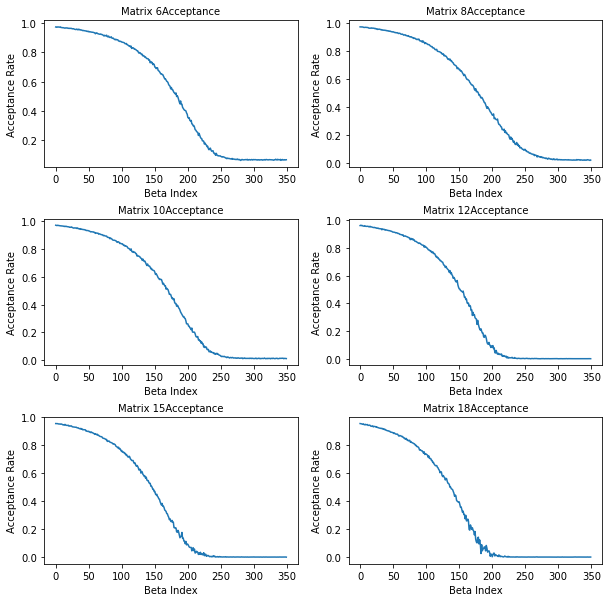

In [67]:
fig,axs = plt.subplots(3,2,num=10)
fig.set_figheight(10)
fig.set_figwidth(10)
fig.subplots_adjust(hspace=0.35)

for i,j in enumerate(acceptance_all):

    ix = np.unravel_index(i, axs.shape)   
    axs[ix].plot(j)
    axs[ix].set_title('Matrix ' + str( titles[i]) + 'Acceptance', fontsize=10)
    axs[ix].set_ylabel('Acceptance Rate')
    axs[ix].set_xlabel('Beta Index')
    
plt.savefig('acceptance_geo.pdf')    
plt.show()

### Calculating Z: Comparing BruteForce and Sampling Results

###### Calculating Partition Functions Linear Schedule

Below are plots, using a linear schedule, of partition functions calcualted from a brute force and old sampling algorithm.

In [377]:
# This section calculates the partition functions at each point of beta up to beta_cutoff.
# It also uses brute force calculations to compare with. The hyper parameters are suitable for the largest graph.

schedule = 'lin' #Set beta schedules, 'lin', 'log' or 'geo'
initial_temperature = 0.01
alpha = 0.85 #for geo schedule
number_beta_points = 350
number_of_samples = 100
mixing_time = 270

ZS = []
ZB = []
betas = []

for i,matrix in enumerate(matrices):
    
    inf_norm = max(np.abs((np.linalg.eig(matrix)[0]))) # infinite norm of matrix is the largest absolute eigenvalue
    beta_cutoff = 0.2 #1/(2*inf_norm)
    betas.append(get_betas(schedule,beta_cutoff,initial_temperature,alpha,number_beta_points))

    Zs = calc_Zbk(betas[i],number_of_samples,mixing_time,matrix)
    Zb = calc_z_bruteforce(betas[i],matrix)
    Zs = (np.insert(Zs,0,1))*(2**matrix.shape[0]) #Add Z0 to the start of the array
    
    ZB.append(Zb)
    ZS.append(Zs)

ZBDF_path = CSV_path + 'ZBDF_{}.csv'.format(schedule)
ZSDF_path = CSV_path + 'ZSDF_{}.csv'.format(schedule)

ZBDF = pd.DataFrame(np.array(ZB).T)
ZSDF = pd.DataFrame(np.array(ZS).T)

ZBDF.to_csv(ZBDF_path)
ZSDF.to_csv(ZSDF_path)

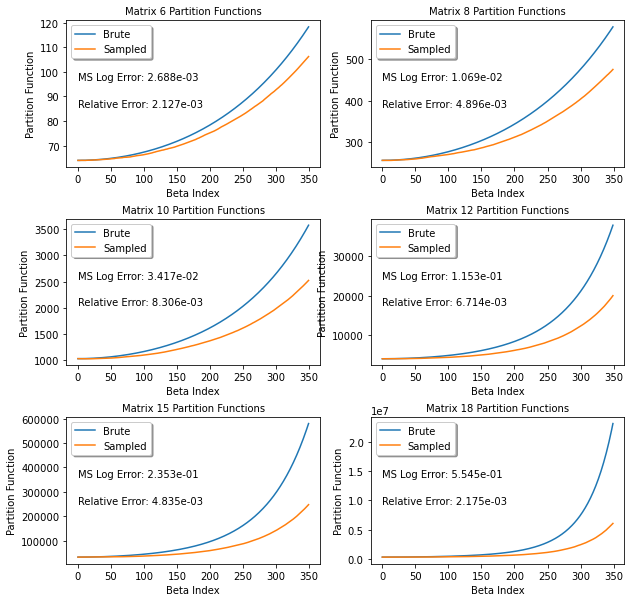

In [434]:
fig,axs = plt.subplots(3,2,num=10)
fig.set_figheight(10)
fig.set_figwidth(10)
fig.subplots_adjust(hspace=0.35)

schedule = 'lin'
ZBDF_path = CSV_path + 'ZBDF_{}.csv'.format(schedule)
ZSDF_path = CSV_path + 'ZSDF_{}.csv'.format(schedule)

ZBDF = pd.read_csv(ZBDF_path)
ZSDF = pd.read_csv(ZSDF_path)
ZBDF = ZBDF.to_numpy().T[1:len(ZBDF)]
ZSDF = ZSDF.to_numpy().T[1:len(ZSDF)]

for i in range(0,len(n)):

    ix = np.unravel_index(i, axs.shape)   
    axs[ix].plot(ZBDF[i])
    axs[ix].plot(ZSDF[i])
    
    axs[ix].set_title('Matrix ' + str( titles[i]) + ' Partition Functions', fontsize=10)
    axs[ix].set_ylabel('Partition Function')
    axs[ix].set_xlabel('Beta Index')
    axs[ix].legend(('Brute','Sampled'), loc='upper left', shadow=True)
    
    log_error = np.format_float_scientific(np.mean((np.log(ZSDF[i]) - np.log(ZBDF[i]))**2), precision=3) # ERROR CALCULATION
    Relative_Error = np.format_float_scientific(np.mean((ZBDF[i]/max(ZBDF[i]) - ZSDF[i]/max(ZSDF[i]))**2),precision=3)
    
    axs[ix].text(0, min(ZBDF[i])+(max(ZBDF[i]) - min(ZBDF[i]))*0.6,'MS Log Error: {}'.format(log_error), fontsize=10)
    axs[ix].text(0, min(ZBDF[i])+(max(ZBDF[i]) - min(ZBDF[i]))*0.4,'Relative Error: {}'.format(Relative_Error), fontsize=10)
    

plt.savefig('Partition_Functions_{}.pdf'.format(schedule))
plt.show()

###### Calculating Lower Bound

Under the linear schedule, the beta calculations are loaded in from a CSV file and the lower bound is plotted. As the graph size increases, errors become larger. The hyperparameters are set up so that they are suitable for the largest graph. 

In [375]:
import warnings
warnings.filterwarnings('ignore')

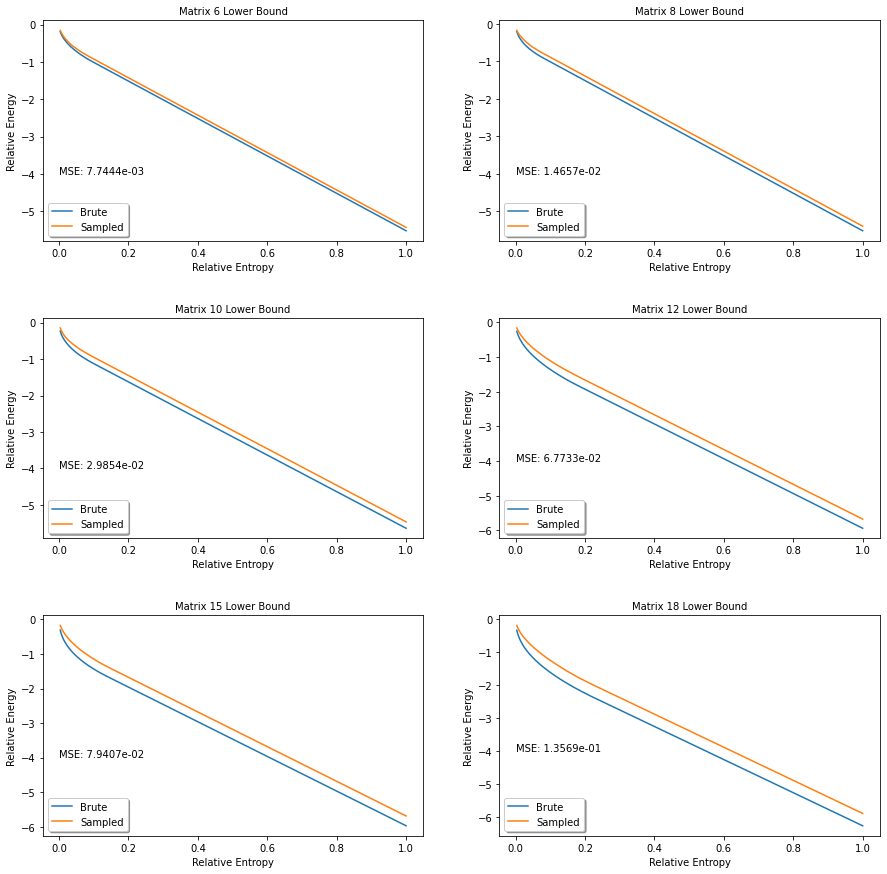

In [425]:
fig,axs = plt.subplots(3,2,num=10)
fig.set_figheight(15)
fig.set_figwidth(15)
fig.subplots_adjust(hspace=0.35)

for i in range(0,len(n)):
    
    ix = np.unravel_index(i, axs.shape)
    x,y = plot_LB(betas[i],ZBDF[i]/(2**n[i]),n[i])
    x1,y1 = plot_LB(betas[i],ZSDF[i]/(2**n[i]),n[i])
    axs[ix].plot(x,y)
    axs[ix].plot(x1,y1)
    axs[ix].set_title('Matrix ' + str( titles[i]) + ' Lower Bound', fontsize=10)
    axs[ix].set_ylabel('Relative Energy')
    axs[ix].set_xlabel('Relative Entropy')
    axs[ix].legend(('Brute','Sampled'), loc='lower left', shadow=True)
    

    y1 = np.array(y1)
    y = np.array(y)
    y1 = y1[~np.isnan(y1)]
    y = y[~np.isnan(y)]
    MSE = np.format_float_scientific(np.mean((y1-y)**2), precision=4)
    
    axs[ix].text(0,-4,'MSE: {}'.format(MSE), fontsize=10)

plt.savefig('LB_small_{}.pdf'.format(schedule))
plt.show()

###### Calculating Partition Functions with Geometric Schedule

Need to justify the initial temperature parameter.

In [426]:
# This section calculates the partition functions at each point of beta up to beta_cutoff.
# It also uses brute force calculations to compare with. The hyper parameters are suitable for the largest graph.

schedule = 'geo' #Set beta schedules, 'lin', 'log' or 'geo'
initial_temperature = 0.01
alpha = 0.85 #for geo schedule
number_beta_points = 350
number_of_samples = 100
mixing_time = 270

ZS = []
ZB = []
betas = []

for i,matrix in enumerate(matrices):
    
    inf_norm = max(np.abs((np.linalg.eig(matrix)[0]))) # infinite norm of matrix is the largest absolute eigenvalue
    beta_cutoff = 0.2 #1/(2*inf_norm) #Taken this up to 0.2 for all graphs.
    betas.append(get_betas(schedule,beta_cutoff,initial_temperature,alpha,number_beta_points))

    Zs = calc_Zbk(betas[i],number_of_samples,mixing_time,matrix)
    Zb = calc_z_bruteforce(betas[i],matrix)
    Zs = (np.insert(Zs,0,1))*(2**matrix.shape[0]) #Add Z0 to the start of the array
    
    ZB.append(Zb)
    ZS.append(Zs)

ZBDF_path = CSV_path + 'ZBDF_{}.csv'.format(schedule)
ZSDF_path = CSV_path + 'ZSDF_{}.csv'.format(schedule)

ZBDF = pd.DataFrame(np.array(ZB).T)
ZSDF = pd.DataFrame(np.array(ZS).T)

ZBDF.to_csv(ZBDF_path)
ZSDF.to_csv(ZSDF_path)

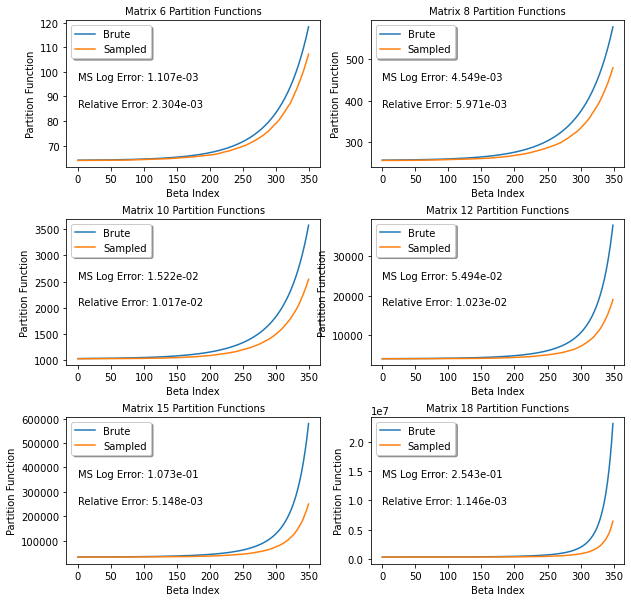

In [435]:
fig,axs = plt.subplots(3,2,num=10)
fig.set_figheight(10)
fig.set_figwidth(10)
fig.subplots_adjust(hspace=0.35)

schedule = 'geo'
ZBDF_path = CSV_path + 'ZBDF_{}.csv'.format(schedule)
ZSDF_path = CSV_path + 'ZSDF_{}.csv'.format(schedule)

ZBDF = pd.read_csv(ZBDF_path)
ZSDF = pd.read_csv(ZSDF_path)
ZBDF = ZBDF.to_numpy().T[1:len(ZBDF)]
ZSDF = ZSDF.to_numpy().T[1:len(ZSDF)]

for i in range(0,len(n)):

    ix = np.unravel_index(i, axs.shape)   
    axs[ix].plot(ZBDF[i])
    axs[ix].plot(ZSDF[i])
    
    axs[ix].set_title('Matrix ' + str( titles[i]) + ' Partition Functions', fontsize=10)
    axs[ix].set_ylabel('Partition Function')
    axs[ix].set_xlabel('Beta Index')
    axs[ix].legend(('Brute','Sampled'), loc='upper left', shadow=True)
    
    log_error = np.format_float_scientific(np.mean((np.log(ZSDF[i]) - np.log(ZBDF[i]))**2), precision=3)
    Relative_Error = np.format_float_scientific(np.mean((ZBDF[i]/max(ZBDF[i]) - ZSDF[i]/max(ZSDF[i]))**2),precision=3)
    
    axs[ix].text(0, min(ZBDF[i])+(max(ZBDF[i]) - min(ZBDF[i]))*0.6,'MS Log Error: {}'.format(log_error), fontsize=10)
    axs[ix].text(0, min(ZBDF[i])+(max(ZBDF[i]) - min(ZBDF[i]))*0.4,'Relative Error: {}'.format(Relative_Error), fontsize=10)
    

plt.savefig('Partition_Functions_{}.pdf'.format(schedule))
plt.show()

###### Plotting Lower Bound - Geometric Schedule

Using a Geometric schedule decreases error compared to linear schedule. Error still increases with increased graph size.

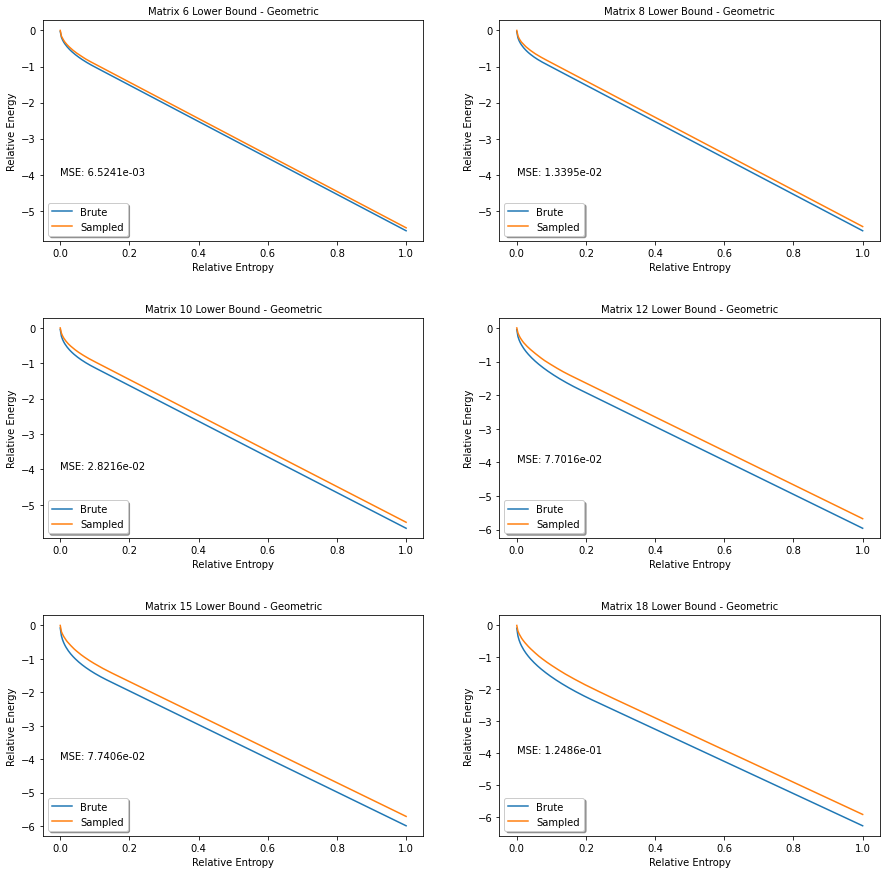

In [428]:
fig,axs = plt.subplots(3,2,num=10)
fig.set_figheight(15)
fig.set_figwidth(15)
fig.subplots_adjust(hspace=0.35)

for i in range(0,len(n)):
    
    ix = np.unravel_index(i, axs.shape)
    x,y = plot_LB(betas[i],ZBDF[i]/(2**n[i]),n[i])
    x1,y1 = plot_LB(betas[i],ZSDF[i]/(2**n[i]),n[i])
    axs[ix].plot(x,y)
    axs[ix].plot(x1,y1)
    axs[ix].set_title('Matrix ' + str( titles[i]) + ' Lower Bound - Geometric', fontsize=10)
    axs[ix].set_ylabel('Relative Energy')
    axs[ix].set_xlabel('Relative Entropy')
    axs[ix].legend(('Brute','Sampled'), loc='lower left', shadow=True)
    

    y1 = np.array(y1)
    y = np.array(y)
    y1 = y1[~np.isnan(y1)]
    y = y[~np.isnan(y)]
    MSE = np.format_float_scientific(np.mean((y1-y)**2), precision=4)
    
    axs[ix].text(0,-4,'MSE: {}'.format(MSE), fontsize=10)

plt.savefig('LB_small_{}.pdf'.format(schedule))
plt.show()

### New Sampling Algorithm

Gibbs state sampler is redefined below to produce samples AFTER the mixing time rather than for each sample. For this experiment, I could only go up to the first 4 matrices, the last 2 took a surprisingly long time. In general, adjusting beta_cutoff determines how long convergence will take especially for the task of showing the last few points appended; the last steps of convergence the collecting samples can be taxing. Overall, the new sampling algorithm converges much more accurately.

In [199]:
#Set Hyper-Parameters
schedule = 'geo' #Set beta schedules, 'lin', 'log' or 'geo'
inf_norm = max(np.abs((np.linalg.eig(matrix)[0]))) # infinite norm of matrix is the largest absolute eigenvalue
beta_cutoff = 3.0 #1/(2*inf_norm)
initial_temperature = 0.01
alpha = 0.85 #for geo schedule
number_beta_points = 500
number_of_samples = 200
mixing_time = 300
betas = get_betas(schedule,beta_cutoff,initial_temperature,alpha,number_beta_points)

global accept_rate

# Convergence with a linearly increasing beta schedule
conv_plots = []
acceptance_all = []

tracker = 0
for matrix in matrices[0:4]:
    
    tracker += 1
    print(tracker)
    
    H_init,S_init = calc_rand_H(matrix,1)
    a1 = []
    accept_rate = []
    for i in betas:
        
        arr = sample_gibbs_state_new(i,matrix,number_of_samples,mixing_time,H_init,S_init)
        a1.append(np.mean(arr[0]))
        
    conv_plots.append(a1)
    acceptance_all.append(accept_rate)

cs_path = CSV_path + 'conv_solve_{}_newsampler.csv'.format(schedule)
conv_solve = pd.DataFrame(np.array(conv_plots).T)
conv_solve.to_csv(cs_path)
cs = pd.read_csv(cs_path).to_numpy().T
cs=cs[1:len(cs)]

acc_path = CSV_path + 'acc_{}_newsampler.csv'.format(schedule)
acc = pd.DataFrame(np.array(acceptance_all).T)
acc.to_csv(acc_path)
acc_all = pd.read_csv(cs_path).to_numpy().T
acc_all=acc_all[1:len(acc_all)]

1
2
3
4


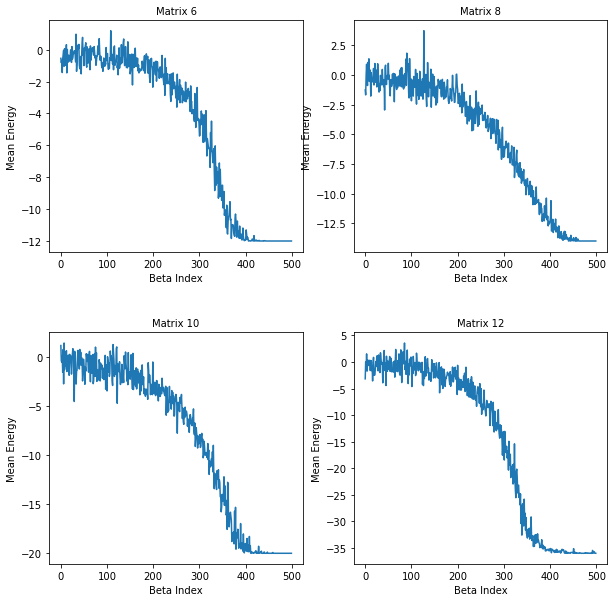

In [201]:
fig,axs = plt.subplots(2,2,num=10)
fig.set_figheight(10)
fig.set_figwidth(10)
fig.subplots_adjust(hspace=0.35)

for i,j in enumerate(cs):

    ix = np.unravel_index(i, axs.shape)   
    axs[ix].plot(j)
    axs[ix].set_title('Matrix ' + str( titles[i]), fontsize=10)
    axs[ix].set_ylabel('Mean Energy')
    axs[ix].set_xlabel('Beta Index')
    
plt.savefig('conv_solve_{}_newsampler.pdf'.format(schedule))    
plt.show()

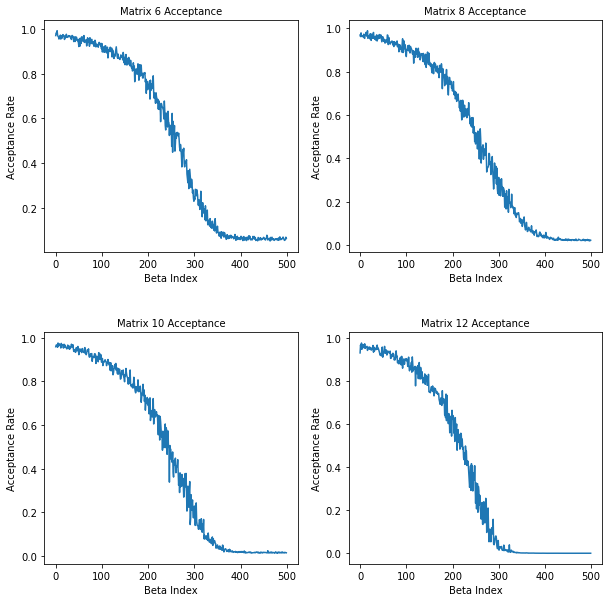

In [205]:
fig,axs = plt.subplots(2,2,num=10)
fig.set_figheight(10)
fig.set_figwidth(10)
fig.subplots_adjust(hspace=0.35)

for i,j in enumerate(acceptance_all):

    ix = np.unravel_index(i, axs.shape)   
    axs[ix].plot(j)
    axs[ix].set_title('Matrix ' + str( titles[i]) + ' Acceptance', fontsize=10)
    axs[ix].set_ylabel('Acceptance Rate')
    axs[ix].set_xlabel('Beta Index')
    
plt.savefig('acceptance_{}_newsampler.pdf'.format(schedule))    
plt.show()

### Big Graph 50 Vertices

This is an experiment with 50 Vertices and takes around 1 hour.

In [1001]:
matrix = generate_random_graph(800)

In [1003]:
beta_cutoff
inf_norm = max(np.abs((np.linalg.eig(matrix)[0]))) # infinite norm of matrix is the largest absolute eigenvalue
beta_cutoff = 1/(2*inf_norm)
beta_cutoff

0.001247715594269449

In [865]:
accept_rate = []
schedule = 'geo' #Set beta schedules, 'lin', 'log' or 'geo'
inf_norm = max(np.abs((np.linalg.eig(matrix)[0]))) # infinite norm of matrix is the largest absolute eigenvalue
beta_cutoff = 0.18
initial_temperature = 0.001
alpha = 0.85 #for geo schedule
number_beta_points = 1000
number_of_samples = 1000
mixing_time = 1000
betas = get_betas(schedule,beta_cutoff,initial_temperature,alpha,number_beta_points)

Zs = calc_Zbk_new(betas,number_of_samples,mixing_time,matrix) # Calculate partition functions up to Z beta[k]
Zs = (np.insert(Zs,0,1))*(2**matrix.shape[0]) #Add Z0 to the start of the array
ZS = Zs

ZSDF_path = CSV_path + 'ZSDF50_{}.csv'.format(schedule)
ZSDF = pd.DataFrame(np.array(ZS).T)
ZSDF.to_csv(ZSDF_path)

[0]
4
0
4
-4
0
-4
-8
-16
16
8
-4
4
4
8
-12
-4
-4
8
4
4
-16
8
4
4
-4
-4
-8
-4
4
-4
8
0
4
0
0
-4
8
-4
4
-4
4
0
-4
4
4
12
-12
-16
4
12
-16
16
-4
-4
0
-4
0
4
-8
4
-4
0
-20
12
-12
8
8
12
-4
4
-4
16
4
-4
-8
-4
4
8
-12
0
-4
12
-12
-4
4
-8
4
-4
0
4
12
0
-4
4
-16
12
-4
8
4
-4
-12
16
-4
4
-4
4
-20
4
-4
20
-4
-8
-12
12
12
0
-8
4
-4
-12
8
-12
4
4
0
12
-12
-12
4
-16
20
-4
4
12
4
0
12
-4
-12
4
0
-4
4
0
0
4
-4
0
0
-4
4
-4
8
-12
4
4
-8
12
0
-4
0
0
4
-4
-4
4
8
0
-20
0
4
4
-4
-4
4
0
-8
8
4
-4
4
4
0
4
4
0
-12
8
0
0
4
-8
8
-12
0
0
0
-8
12
-12
-4
4
-4
12
-12
4
0
-8
0
4
8
8
-8
8
-8
-4
12
-4
-24
4
12
12
-4
-4
-4
-12
-12
12
24
4
-4
-8
-4
-8
4
12
-4
-8
4
4
-4
-8
16
0
-12
12
-4
8
12
4
-4
0
-20
4
20
-8
-4
-8
4
-4
-4
4
-4
16
-8
4
-4
4
-8
-12
16
-20
4
-4
-16
24
-16
-8
-16
16
4
12
0
4
0
-4
0
-12
4
12
-8
-20
-4
4
20
-20
16
-16
12
8
4
0
4
-4
-12
8
-8
8
-8
4
12
0
-8
0
8
-4
-4
-4
4
0
-12
4
-4
16
-4
-8
4
-4
8
0
0
0
8
0
-4
4
-4
-12
8
8
-4
-4
4
0
0
12
0
-4
-8
4
0
0
4
-8
8
-4
-4
4
-4
-4
0
12
-4
-4
-4
4
-4
4
-8
8
-8
4
-4
4


-12
4
-12
4
4
-4
4
-4
12
-12
8
4
-8
-8
4
-16
20
20
-4
0
-4
8
-12
-4
4
0
-8
0
-4
-8
4
-4
4
12
8
4
-8
4
8
-8
-16
4
12
-4
8
-4
4
-8
4
-8
-4
-24
24
4
-16
-4
4
16
-16
4
-4
12
-4
12
8
-4
0
0
-16
12
0
0
-4
-4
-12
-12
4
4
4
12
8
0
-4
0
-4
4
4
0
4
-12
-12
8
-4
-4
16
12
0
0
-12
-16
12
-8
12
-4
4
-8
-8
16
4
0
0
0
-16
16
-16
8
0
0
8
-4
-8
-16
-12
-12
16
-16
16
24
4
4
0
-4
-8
-8
8
0
12
4
-8
-20
12
-4
4
-12
-4
20
20
-20
-20
20
8
0
8
0
0
4
0
-4
-8
-12
4
-4
4
0
0
8
-20
20
8
0
-8
12
-12
-16
4
8
-4
4
8
-12
-8
-4
4
4
-16
-4
-12
12
-12
12
-12
16
12
8
4
0
0
-12
8
-8
4
-4
0
-8
16
4
-4
4
8
-12
4
-8
-8
4
4
8
-4
0
-4
-4
-4
-12
12
-12
16
-4
-4
4
4
4
0
0
-4
-16
12
-8
8
12
-8
4
-8
4
8
4
4
0
-8
-4
4
-12
4
-8
12
-8
4
-4
4
-4
20
-20
-20
20
20
-20
4
-12
8
4
-12
8
-8
16
-4
4
4
-8
8
-4
4
4
0
-4
-12
8
-4
12
-4
4
-4
4
0
-4
-4
4
-8
-4
4
-12
16
0
-12
12
-12
4
0
4
-4
0
-4
-8
12
12
12
-8
-4
-4
8
4
-12
4
4
4
8
-12
0
-12
-8
-4
4
12
0
-12
12
-12
12
-8
-4
12
12
-8
-16
12
8
-8
-4
-4
4
-4
12
-4
4
4
4
-4
-8
0
0
-8
8
-4
-8
8
8
4
4
-

-8
-12
4
8
-12
8
4
-4
-8
12
-12
12
4
-8
0
12
-12
-4
0
12
0
4
-8
-16
16
4
-8
4
-4
-12
16
8
0
4
-20
8
-12
16
-16
12
12
0
-4
0
-8
0
0
0
-8
20
0
-8
-16
-4
16
4
8
4
-4
-8
8
-12
0
0
12
4
-4
-4
0
0
4
0
-4
-8
-12
8
4
8
-4
-4
-12
4
16
-16
-4
-16
12
8
4
0
-4
0
8
-4
4
-24
4
0
20
-8
8
-8
8
0
-12
8
0
0
4
4
-16
12
-4
12
4
8
-4
-12
0
-12
12
-4
4
-4
-8
4
4
8
0
-4
-4
8
-8
-4
8
4
-8
4
-4
-4
4
4
-12
4
4
-4
4
4
-4
4
-4
-4
8
4
0
0
-4
-8
-8
4
-8
4
-20
4
16
4
-4
-16
12
4
20
0
0
0
-12
8
-8
8
-4
-8
4
-4
4
-4
-4
12
-12
0
0
8
8
-4
0
4
-4
8
-4
-12
12
4
-8
8
-4
-12
12
0
4
0
-8
8
4
-8
-4
-4
4
0
-12
-12
12
8
12
0
0
0
0
4
-4
0
0
0
-12
-12
0
16
-4
0
4
0
-8
-4
4
-8
8
-8
8
0
4
4
-4
4
0
12
4
4
-8
-8
-12
8
8
0
-16
12
-12
4
-4
-24
4
24
-8
12
4
4
-4
-4
4
0
-8
-4
16
-4
0
-4
0
4
-4
0
-12
4
12
4
-4
0
0
-8
8
-4
-12
16
-4
-16
12
4
4
8
-8
-4
0
4
-4
0
4
-4
-12
-12
12
4
0
0
-8
16
-16
8
-8
16
8
0
-4
4
-8
4
8
-4
4
0
4
-20
20
-20
0
-4
12
12
-12
-8
-4
12
4
-4
0
0
-4
8
4
-4
0
-4
-8
8
-4
-8
-12
4
-4
12
4
4
4
-12
12
-12
0
4
4
0
0
0
0
-4
4

-4
0
8
4
-4
12
4
-8
-8
8
8
-4
-4
-16
12
4
4
-4
-4
8
4
-4
-4
0
0
4
0
-20
12
8
4
4
-4
4
-4
4
-16
-8
12
0
4
0
-4
4
-12
-8
12
8
-4
4
-8
-4
0
-12
16
-8
8
0
0
4
0
0
4
-4
8
-4
-12
-4
8
8
-8
12
-8
4
-4
4
4
-4
-20
20
-4
-12
8
8
-8
4
4
0
-4
4
-8
0
0
4
16
-12
0
12
-20
8
0
0
-12
-4
4
0
0
12
4
4
-4
4
-16
16
-4
-12
12
-8
4
8
-12
4
-12
-12
8
12
-12
20
-4
0
0
-4
8
-4
4
-4
4
0
4
-8
8
-4
-20
4
-4
12
-4
16
4
0
-4
-4
-12
0
-8
8
4
4
4
-12
12
-12
-4
0
4
-4
12
4
4
-4
-4
-4
-4
4
4
8
-4
-8
8
-8
-20
-4
-16
20
4
8
-4
4
0
-4
4
-4
12
0
-4
4
0
-4
-4
4
-8
20
0
-12
-8
-4
8
-12
4
16
-4
-4
-4
-4
4
4
-4
4
-24
12
0
16
-16
0
-4
16
0
4
-4
-8
-16
-24
-4
12
12
12
0
4
-4
-16
4
16
-16
4
-4
4
8
-4
-4
-8
4
8
-12
16
8
-16
-4
-8
4
-4
8
0
0
0
16
4
-12
-20
8
12
12
-12
4
-8
8
-8
-4
8
8
-4
-12
12
4
4
-8
-8
4
4
-8
8
-20
4
12
0
0
4
-4
-4
-4
4
-4
12
-12
0
-4
12
12
-4
-4
-8
8
0
-8
-16
16
12
-12
4
12
-4
-12
4
12
-12
12
-12
12
-12
-8
0
-4
-4
8
-4
0
12
4
-4
-8
-4
4
4
-4
8
-4
4
0
0
4
4
8
-4
-20
8
-8
8
4
4
-4
4
-4
-4
4
-8
8
-4
-8
8
-4
0
-4
-8


12
4
-4
-12
12
-4
-4
0
8
0
0
-4
4
4
4
-4
-4
0
-12
12
-4
0
4
-4
-4
8
-12
4
-4
-8
8
12
0
0
0
0
-4
4
-4
4
-12
-4
8
-4
4
8
-8
4
-4
4
-4
4
-4
4
-4
-24
16
12
-8
8
4
-4
-4
4
0
-4
8
-4
-8
12
4
-4
0
-4
0
-4
-8
-12
12
0
0
-4
4
8
4
0
-4
0
4
0
-4
0
-4
-12
-16
0
12
-12
8
4
-16
12
0
0
0
8
-12
12
0
-8
8
4
-4
4
-4
-8
-4
4
-4
0
4
-4
-8
4
4
12
-4
-12
8
-4
-4
-8
0
-4
-4
8
4
-4
16
4
0
0
-4
4
0
12
-4
-4
0
-4
-4
-4
4
4
16
-4
-12
-4
-12
4
12
-4
8
-4
4
-4
4
-4
4
0
-8
12
-20
8
-4
4
4
4
-4
-4
4
-8
-4
12
8
-4
-8
8
-12
-16
16
12
-4
-4
-16
16
0
0
-4
8
-8
0
-8
8
-4
12
-4
-12
8
-8
-16
8
4
16
0
-4
4
-8
0
0
4
0
4
8
-4
8
-4
0
-12
4
-8
8
0
0
4
-8
4
-4
0
0
4
0
8
0
-12
-4
-16
-24
16
20
12
-4
8
0
4
-8
4
0
-4
-4
-4
4
0
0
0
0
0
-4
0
8
-8
4
-16
0
4
16
-4
8
0
-8
-4
4
-8
20
4
0
-12
4
12
-16
0
0
-4
4
12
-12
-4
12
0
-8
8
-4
8
-12
-4
4
-4
12
-4
-12
-8
-8
20
12
4
4
-12
-12
20
0
-12
4
0
-4
-4
12
-8
-12
8
4
4
4
-12
4
-8
12
-4
-4
8
0
0
-12
4
-12
-8
-24
-8
12
-12
12
4
-4
24
4
-12
-8
8
4
4
-4
0
4
4
0
4
-4
4
0
-12
8
0
-8
12
-12
-8
8
-4
1

12
-4
4
0
-4
4
-8
-20
16
-4
12
4
-4
4
4
-8
-8
8
4
-12
4
8
-4
4
0
-4
-16
12
-12
8
4
8
12
-4
-4
4
-4
4
-4
-16
4
4
-4
0
-4
4
-4
4
0
-4
0
4
4
-4
-12
8
8
4
-8
4
-4
12
-16
-12
20
4
0
0
0
-8
4
4
0
0
4
-12
4
4
-8
0
0
-4
4
-4
4
-16
-12
12
-4
16
0
-16
-12
16
12
4
-12
12
0
0
0
-4
0
-12
4
4
-4
8
4
-4
-4
4
4
-4
8
-4
0
-4
4
4
-4
-4
4
-4
0
4
4
0
0
0
0
-12
-4
12
-4
0
8
12
0
-4
-8
-12
0
12
-12
-4
4
12
-4
-12
0
0
4
-4
4
-8
4
-4
4
-8
8
-8
-4
4
4
-8
0
0
8
4
4
-4
4
4
-4
-8
-4
-4
0
8
0
4
12
0
-4
0
-12
-4
4
8
-12
0
12
0
-4
-12
-8
16
0
4
-4
12
4
0
-4
-20
8
-4
-8
4
0
8
4
-4
0
4
4
-4
-4
-12
8
0
12
0
-4
0
4
-4
0
-12
8
-8
4
-4
16
-8
-4
0
12
-8
8
-4
-8
-8
-16
16
-20
16
4
-8
-8
8
-8
20
8
-8
12
-4
0
4
-8
4
0
4
-8
0
12
-4
-12
-8
12
4
-4
4
-4
-12
12
4
-4
0
0
4
-4
4
8
-8
4
-4
8
4
-8
-16
8
4
-4
4
4
4
-16
-4
-4
0
0
-4
16
-4
12
0
4
0
0
0
4
0
4
-4
0
-4
-4
-12
8
-12
8
4
4
-4
0
4
-12
-4
8
-8
12
0
-4
-4
4
-4
-8
12
-8
20
0
-4
4
0
0
-8
-4
0
4
0
-8
-8
20
8
-8
-4
4
-4
8
4
-4
-8
-4
4
-8
-16
-12
20
-4
4
12
-12
20
4
-12
-12
4
-4
4
4

4
4
-8
-8
12
-12
12
-12
-4
4
-4
4
16
-4
-4
0
4
-4
4
-8
4
0
4
4
-4
-8
8
8
-12
0
4
4
-4
-4
-4
4
-8
8
-4
-4
4
8
0
4
4
-4
0
-4
-4
-12
12
4
-4
-4
-16
16
-4
8
4
-4
-8
4
0
8
-4
0
8
4
0
-4
-4
4
-12
4
4
-4
4
-4
4
8
-8
-12
-4
16
4
-4
-16
12
12
-4
8
-12
-8
0
8
12
-8
-4
8
-12
12
-8
4
-8
0
8
4
-8
-12
8
-4
0
-4
8
-8
8
0
-4
8
4
4
-8
8
8
-8
-8
-12
-24
24
4
-4
-12
8
12
8
-12
-8
12
-16
16
4
16
-4
-8
12
-12
8
0
0
-8
4
0
-8
8
4
-4
4
-12
4
4
-8
4
-8
-12
16
4
4
4
0
-4
0
-4
4
4
-8
-12
4
12
-4
4
-12
4
-8
12
0
0
0
-8
8
-8
12
4
-8
-8
-4
8
4
-8
4
0
-8
12
0
12
-16
-4
4
-4
4
-4
-8
8
8
0
-8
0
0
-4
12
-8
8
-4
0
0
4
4
0
0
4
4
0
4
-8
-12
-4
12
-8
0
0
4
0
-8
8
-12
-12
12
4
8
-4
-4
8
-4
4
-8
-4
16
-16
12
4
-16
12
4
-4
4
4
-12
12
0
-8
-16
-4
4
8
-8
12
0
-4
16
-4
-12
4
-4
-8
-4
16
4
-4
-12
12
-4
-8
4
12
4
-4
-4
4
0
-8
-12
-4
4
12
4
-4
-12
12
-12
8
4
12
-4
4
-4
-16
16
-16
12
8
-8
-4
8
0
0
4
-4
-12
4
-8
-20
12
12
12
4
0
4
-8
8
-4
-12
-8
-12
12
8
-8
12
4
0
-4
4
-4
8
-8
4
-4
-8
-4
8
4
-4
4
-4
4
0
0
0
0
-4
-12
12
4
-8
8
0
0
4


KeyboardInterrupt: 

In [600]:
x,y = plot_LB(betas,ZSDF.to_numpy()/(2**50),50)

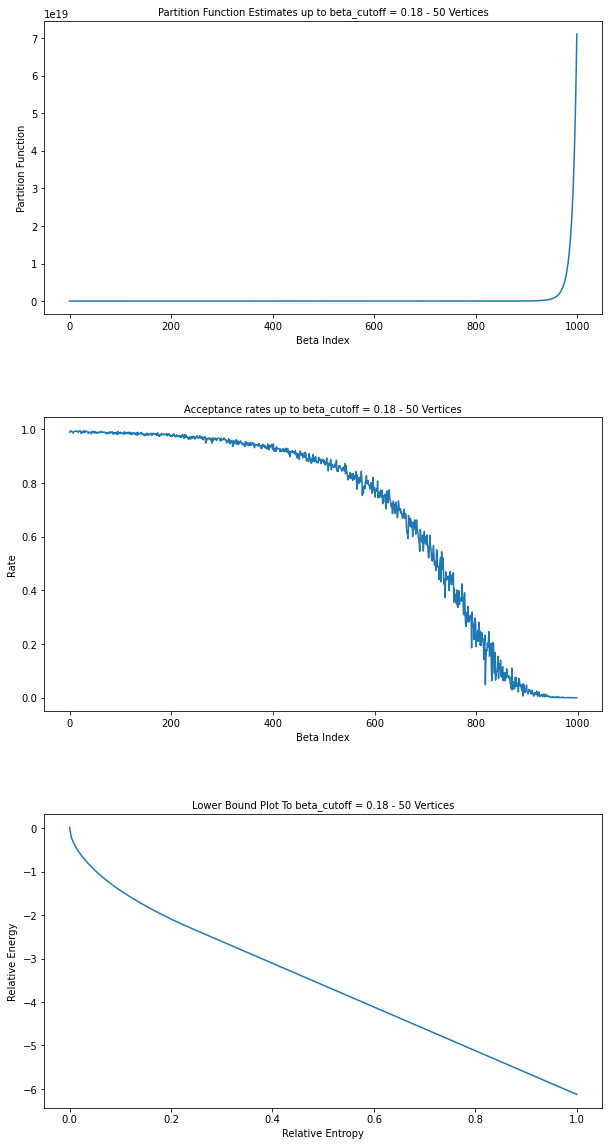

In [483]:
fig,axs = plt.subplots(3,1,num=10)
fig.set_figheight(20)
fig.set_figwidth(10)
fig.subplots_adjust(hspace=0.35)

ix = 0
axs[ix].plot(ZSDF)
axs[ix].set_title('Partition Function Estimates up to beta_cutoff = 0.18 - 50 Vertices', fontsize=10)
axs[ix].set_ylabel('Partition Function')
axs[ix].set_xlabel('Beta Index')

ix = 1
axs[ix].plot(accept_rate)
axs[ix].set_title('Acceptance rates up to beta_cutoff = 0.18 - 50 Vertices', fontsize=10)
axs[ix].set_ylabel('Rate')
axs[ix].set_xlabel('Beta Index')

ix = 2
axs[ix].plot(x,y)
axs[ix].plot()
axs[ix].set_title('Lower Bound Plot To beta_cutoff = 0.18 - 50 Vertices', fontsize=10)
axs[ix].set_ylabel('Relative Energy')
axs[ix].set_xlabel('Relative Entropy')


plt.savefig('BIG50_newsampler.pdf'.format(schedule))    
plt.show()